In [1]:
%config InlineBackend.figure_formats = ['png']
from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt
import json
from ptbinnedfittinghelpers import *
from templatefitting import *

In [2]:
lumi = 140 # [fb^-1]

# 1D fits
## loading data and templates

In [3]:
# def load_data(path_to_data, value_key="yvals"):
#     """
#     Loads data from JSON file
#     :param path_to_data: 
#     :return: xe, dx, n
#     """
#     # load data
#     with open(path_to_data, 'r') as f:
#         data = json.load(f)
#     xe = np.array(data['bins'])
#     dx = xe[1] - xe[0]
#     n = np.array(data[value_key]) * dx * lumi
#     return xe, dx, n
    
# xe_cos, dx_cos, n_cos = load_data('templates/data_2d_nocuts/costheta.json')
# xe_phi, dx_phi, n_phi = load_data('templates/data_2d_nocuts/phi.json')

In [4]:
# def load_temps(pathtotemps, prefix):
#     """
#     Loads templates from JSON file
#     :param pathtotemps: 
#     :param prefix: 
#     :return: template
#     """
#     # load templates
#     filenames = []
#     for i in range(9):
#         filenames.append(prefix + str(i) + '.json')
#     #     filenames.append('temps_phi' + str(i) + '.json')
    
#     temps = {}
#     t = []
#     for f in filenames:
#         with open(pathtotemps + f, 'r') as g:
#             temps[f] = json.load(g)
#             t.append(np.array(temps[f]['yvals']))
#             for k in temps[f].keys():
#                 temps[f][k] = np.array(temps[f][k])
#     t = np.array(t).T
#     return t
# t_cos = load_temps('data/data_all/', 'temps_cos')
# t_phi = load_temps('data/data_all/', 'temps_phi')

In [5]:
# #load reference coefficients
# coeff = []
# with open('coeffs.txt', 'r') as g:
#     for i in range(8):
#         coeff.append(float(g.readline()))
# coeff = np.array(coeff)

In [6]:
# Setup
cuts = 'cuts'

pathtoptbins = '/home/maltem/Nextcloud/TU_Dresden/Bachelorthesis/minuitfitting/data_inclusive/ptbins.txt'
pathtodata = '/home/maltem/Nextcloud/TU_Dresden/Bachelorthesis/minuitfitting/data_inclusive/histo_'+cuts
pathtocoeffs = '/home/maltem/Nextcloud/TU_Dresden/Bachelorthesis/minuitfitting/data_inclusive/histo_nocuts'
pathtotemplates = 'templates/inclusive/Zjj_inclusive_temps_'+cuts+'0'

_load = 'full'
overflow = False

In [7]:
data, temps, ptbins, angbins, coeffs = load(pathtodata, pathtotemplates, pathtoptbins, pathtocoeffs, _load, overflow)

full
loading full data from /home/maltem/Nextcloud/TU_Dresden/Bachelorthesis/minuitfitting/data_inclusive/histo_cuts with 1 bins
loading full templates from templates/inclusive/Zjj_inclusive_temps_cuts0 with 1 bins
LOADING:  templates/inclusive/Zjj_inclusive_temps_cuts0/ptbin0_2D0.json
LOADING:  templates/inclusive/Zjj_inclusive_temps_cuts0/ptbin0_2D1.json
LOADING:  templates/inclusive/Zjj_inclusive_temps_cuts0/ptbin0_2D2.json
LOADING:  templates/inclusive/Zjj_inclusive_temps_cuts0/ptbin0_2D3.json
LOADING:  templates/inclusive/Zjj_inclusive_temps_cuts0/ptbin0_2D4.json
LOADING:  templates/inclusive/Zjj_inclusive_temps_cuts0/ptbin0_2D5.json
LOADING:  templates/inclusive/Zjj_inclusive_temps_cuts0/ptbin0_2D6.json
LOADING:  templates/inclusive/Zjj_inclusive_temps_cuts0/ptbin0_2D7.json
LOADING:  templates/inclusive/Zjj_inclusive_temps_cuts0/ptbin0_2D8.json
LOADING:  templates/inclusive/Zjj_inclusive_temps_cuts0/ptbin0_cos0.json
LOADING:  templates/inclusive/Zjj_inclusive_temps_cuts0/ptbin0_c

In [8]:
xe_cos = np.array(angbins[0]); xe_phi = np.array(angbins[1])
dx_cos = xe_cos[1] - xe_cos[0]; dx_phi = xe_phi[1] - xe_phi[0]
n_cos = data["cos"][0] * dx_cos * lumi; n_phi = data["phi"][0] * dx_phi * lumi

In [9]:
t_cos = np.array(temps["cos"][0]).T
t_phi = np.array(temps["phi"][0]).T

In [10]:
# 2D
xe = np.array(angbins)
dx = np.array((xe[0,1] - xe[0, 0], xe[1,1] - xe[1, 0]))
da = np.prod(dx)
ts = np.array(temps["2D"][0])
n = data["2D"][0] * da * lumi

In [11]:
coeff = np.array(coeffs[0])[:-1]
print(coeff)

[ 1.38534067e+00 -1.19946255e-02  3.82936990e-01 -9.35606816e-04
 -3.85649377e-03 -1.44804753e-02  2.98316512e-03  1.18046907e-02]


## some helper functions for plotting

In [12]:
def plot_fit(xe, data, m, t, coeffs=np.ones(9), xlabel='$\cos(\\theta)$', ylabel='# Events'):
    with plt.rc_context({
        'font.size': 12,  # Base font size
        'axes.labelsize': 12,  # Axis label font size
        'axes.titlesize': 14,  # Title font size
        'xtick.labelsize': 10,  # X-tick label font size
        'ytick.labelsize': 10,  # Y-tick label font size
        'legend.fontsize': 10  # Legend font size
        }):
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace':0.05}, figsize=(12, 10))
        dx = xe[1] - xe[0]
        x = xe[:-1] + dx / 2
        bins = len(xe) - 1
        y = np.zeros(bins)
        ypos = np.zeros(bins)
        yneg = np.zeros(bins)
        # xi = np.array(m.values)
        for i, p in enumerate(m.parameters):
            y += m.values[p]/coeffs[i] * t[:,i] * dx * lumi
            if p in m.merrors.keys():
                ypos += (m.values[p]/coeffs[i] + m.merrors[p].upper) * t[:,i] * dx * lumi
                yneg += (m.values[p]/coeffs[i] + m.merrors[p].lower) * t[:,i] * dx * lumi
            else:
                ypos += m.values[p]/coeffs[i] * t[:,i] * dx * lumi
                yneg += m.values[p]/coeffs[i] * t[:,i] * dx * lumi

        errkwargs = dict(fmt='ok', elinewidth=1, capsize=2, capthick=1)
        ax1.errorbar(x, data, xerr=dx/2 * np.ones_like(x), yerr=np.sqrt(data), **errkwargs, label='data')
        ax1.stairs(ypos, xe, baseline=yneg, fill=True, alpha= 0.5, label='fit-error')
        # ax.stairs(y, xe, color='b', baseline=np.min(np.append(data, yneg)) - 10, alpha=1, label='fit')
        ax1.stairs(y, xe, color='b', alpha=1, label='fit')
        ax1.legend()

        ratio = y / data
        ratiopos = ypos / data
        rationeg = yneg / data
        print(ratiopos, rationeg, ratio)
        dylim = max(np.max(1-rationeg), np.max(ratiopos-1), np.max(1/np.sqrt(data)))

        ax2.errorbar(x, np.ones_like(x), xerr=dx/2 * np.ones_like(x), yerr=1/np.sqrt(data), label='data', **errkwargs )
        ax2.stairs(ratiopos, xe, baseline=rationeg, fill=True, alpha= 0.5, label='fit-error')
        # ax.stairs(ratio, xe, color='b', baseline=np.min(np.append(data, rationeg)) - 10, alpha=1, label='fit')
        ax2.stairs(ratio, xe, color='b', baseline=None, alpha=1, linewidth=2, label='fit')
        offset = 1.4
        ax2.set_ylim(1-dylim * offset , 1+dylim * offset)
        # ax2.legend()

        ax1.set_ylabel(ylabel)
        ax2.set_xlabel(xlabel)
        ax2.set_ylabel('Fit / Data')
        plt.show()
    return fig, (ax1, ax2)

In [13]:
def plot_cos_phi(xe_cos, xe_phi, data_cos, data_phi, m, t_cos, t_phi, coeffs=np.ones(9)):
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs[0].set_xlabel('$\cos(\\theta)$')
    axs[1].set_xlabel('$\phi$')
    axs[0].set_ylabel('#Events')
    axs[1].set_ylabel('#Events')
    
    plot_fit(axs[0], xe_cos, data_cos, m, t_cos, coeffs)
    plot_fit(axs[1], xe_phi, data_phi, m, t_phi, coeffs)
    plt.show()
    return fig, axs

def log_likelihood(xi):
    xi = np.array(xi)
    lam = np.sum(t_cos * xi * lumi * dx_cos, axis=1)
    for i in range(40):
        if lam[i] < 0:
            print(lam[i])
    l =-1 * np.sum((np.log(lam).T * n_cos).T - lam)
    return l
log_likelihood.errordef = Minuit.LIKELIHOOD
m = Minuit(log_likelihood, np.ones(9))

m.migrad()
m.minos()

## cost functions as classes

In [14]:
# class TemplateFits_1set():
    
#     def __init__(self, xe, templates_cos, data_cos, coeffs=np.ones(9), lumi=140, _2d=False):
#         if not _2d:
#             self.xe = np.array(xe)
#             self.dx = xe[1] - xe[0]
#             self.data_cos = np.array(data_cos)
#             self.templates_cos = np.array(templates_cos)
#             self.lumi = lumi
#             self.errordef = Minuit.LIKELIHOOD
#             self.coeffs = coeffs
#         else:
#             raise Exception("Not implemented yet")
        
    
#     def __call__(self, xi):
#         xi = np.array(xi)/self.coeffs
#         lam_cos = xi[-1] * np.sum(self.templates_cos * np.append(xi[:-1], 1) * self.lumi * self.dx, axis=1)
#         for i in range(len(lam_cos)):
#             if lam_cos[i] < 0:
#                 print(lam_cos[i])
#         l =-1 * np.sum((np.log(lam_cos).T * self.data_cos).T - lam_cos)
#         return l
    
# def fit():
#     temp = TemplateFits(xe_cos, t_cos, n_cos, np.append(coeff, 1))
#     m = Minuit(temp, np.ones(9))
#     m.migrad()
#     m.minos()
#     fig, ax = plt.subplots()
#     ax.set_xlabel('$\cos(\\theta)$')
#     ax.set_ylabel('#Events')
#     plot_fit(ax, temp.xe, temp.data, m, temp.templates, coeffs=temp.coeffs)
    

In [15]:
# class TemplateFits_2d():
    
#     def __init__(self, dx, templates_cos, data_cos, coeffs=np.ones(9), lumi=140, _2d=False):
#         if not _2d:
#             self.dx = dx
#             self.data_cos = np.array(data_cos)
#             self.templates_cos = np.array(templates_cos)
#             self.lumi = lumi
#             self.errordef = Minuit.LIKELIHOOD
#             self.coeffs = coeffs
#         else:
#             raise Exception("Not implemented yet")
        
    
#     def __call__(self, xi):
#         # norm = xi[0]
#         # xi = (np.array(xi)/self.coeffs)[1:]
#         lam_cos = np.sum(self.templates_cos * xi * self.lumi * self.dx, axis=1)
#         # lam_cos = norm * np.sum(self.templates_cos * xi * self.dx, axis=1)
#         for i in range(len(lam_cos)):
#             if lam_cos[i] < 0:
#                 print(lam_cos[i])
#         l =-1 * np.sum((np.log(lam_cos).T * self.data_cos).T - lam_cos)
#         return l
    
# def fit():
#     temp = TemplateFits(xe_cos, t_cos, n_cos, np.append(coeff, 1))
#     m = Minuit(temp, np.ones(9))
#     m.migrad()
#     m.minos()
#     fig, ax = plt.subplots()
#     ax.set_xlabel('$\cos(\\theta)$')
#     ax.set_ylabel('#Events')
#     plot_fit(ax, temp.xe, temp.data, m, temp.templates, coeffs=temp.coeffs)
    

In [16]:
# class TemplateFits():
    
#     def __init__(self, xe_cos, xe_phi, templates_cos, data_cos, templates_phi, data_phi, coeffs=np.ones(9), lumi=140, _2d=False):
#         if not _2d:
#             self.xe_cos = np.array(xe_cos)
#             self.xe_phi = np.array(xe_phi)
#             self.dx_cos = xe_cos[1] - xe_cos[0]
#             self.dx_phi = xe_phi[1] - xe_phi[0]
#             self.data_cos = np.array(data_cos)
#             self.templates_cos = np.array(templates_cos)
#             self.data_phi = np.array(data_phi)
#             self.templates_phi = np.array(templates_phi)
#             self.lumi = lumi
#             self.errordef = Minuit.LIKELIHOOD
#             self.coeffs = coeffs
#         else:
#             raise Exception("Not implemented yet")
        
    
#     def __call__(self, xi):
#         xi = np.array(xi)/self.coeffs
#         lam_cos = np.sum(self.templates_cos * xi * self.lumi * self.dx_cos, axis=1)
#         lam_phi = np.sum(self.templates_phi * xi * self.lumi * self.dx_phi, axis=1)
#         for i in range(len(lam_cos)):
#             if lam_cos[i] < 0:
#                 print(lam_cos[i])
#         l =-1 * (np.sum((np.log(lam_cos).T * self.data_cos).T - lam_cos) + np.sum((np.log(lam_phi).T * self.data_phi).T - lam_phi))
#         return l
    
# def fit():
#     temp = TemplateFits(xe_cos, t_cos, n_cos, np.append(coeff, 1))
#     m = Minuit(temp, np.ones(9))
#     m.migrad()
#     m.minos()
#     fig, ax = plt.subplots()
#     ax.set_xlabel('$\cos(\\theta)$')
#     ax.set_ylabel('#Events')
#     plot_fit(ax, temp.xe_cos, temp.data, m, temp.templates, coeffs=temp.coeffs)
    

In [17]:
# def rebin_histogram(counts, n):
#     if len(counts) % n != 0:
#         counts = counts[:len(counts) - (len(counts) % n)]  # Trim to make it divisible by n
#     return counts.reshape(-1, n).sum(axis=1)

# def rebin_2d_histogram(hist2d, m, n, edges=None):
#     # Check if the histogram dimensions are divisible by m and n; if not, trim them
#     new_shape = (hist2d.shape[0] // m * m, hist2d.shape[1] // n * n)
#     hist2d_trimmed = hist2d[:new_shape[0], :new_shape[1]]
    
#     # Reshape and sum to rebin
#     rebinned_hist = hist2d_trimmed.reshape(new_shape[0] // m, m, new_shape[1] // n, n).sum(axis=(1, 3))
    
#     # if edges rebin edges
#     if edges:    
#         rebinned_x_edges = edges[0,:][::n]
#         rebinned_y_edges = edges[1,:][::n]
#         return rebinned_hist, np.array((rebinned_x_edges, rebinned_y_edges))
    
#     return rebinned_hist

# def rebin_helper(hist, m, n):
#     if hist.ndim == 1:
#         newdim = int(np.sqrt(len(hist)))1.000 	0.0
#         temp = hist.reshape(newdim, newdim)
#         new = rebin_2d_histogram(temp, m, n)
#         new = new.flatten()
#         return new
    
#     elif hist.ndim == 2:
#         t = []
#         for i in range(hist.shape[0]):
#             newdim = int(np.sqrt(len(hist[i,:])))
#             temp = hist[i,:].reshape(newdim, newdim)
#             new = rebin_2d_histogram(temp, m, n)
#             new = new.flatten()
#             t.append(new)
#         t = np.array(t)
#         return t       

# def rebin(data, temps, m, n):
#     return rebin_helper(data, m, n), rebin_helper(temps, m, n)
    

## trying some fitting

### phi with ref_coeffs = 1

In [18]:
np.append(140, np.ones(9))

array([140.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.])

In [19]:
# fit phi
m1 = Minuit(TemplateFits_2d(dx_phi, t_phi, n_phi, lumi=lumi), np.ones(9))
m1.fixed[[0,1,4,6]] = True
m1.migrad()
m1.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.933e+04                 │              Nfcn = 317              │
│ EDM = 2.01e-11 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ x1   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 2 │ x2   │   1.00    │   0.27    │   -0.28    │    0.27    │         │         │       │
│ 3 │ x3   │     0     │    40     │    -40     │     40     │         │         │       │
│ 4 │ x4   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 5 │ x5   │    1.0    │    2.7    │    -2.7    │    2.7     │         │         │       │
│ 6 │ x6   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 7 │ x7   │    1.0    │    2.4    │    -2.4    │    2.4     │         │         │       │
│ 8 │ x8   │   1.000   │   0.016   │   -0.016   │   0.016    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          x2           │          x3           │          x5           │          x7           │          x8           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.28   │   0.27    │    -40    │    40     │   -2.7    │    2.7    │   -2.4    │    2.4    │  -0.016   │   0.016   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬──────────────────────────────────────────────────────────────────────────────────┐
│    │       x0       x1       x2       x3       x4       x5       x6       x7       x8 │
├────┼──────────────────────────────────────────────────────────────────────────────────┤
│ x0 │        0        0     0.00      0e3        0        0        0        0        0 │
│ x1 │        0        0     0.00      0e3        0        0        0        0        0 │
│ x2 │     0.00     0.00   0.0756    -0.07     0.00     0.00     0.00    -0.00  2.35e-3 │
│ x3 │      0e3      0e3    -0.07 1.95e+03      0e3        0      0e3        1 -3.15e-3 │
│ x4 │        0        0     0.00      0e3        0        0        0        0

[1.0002256  0.99186    1.03697525 1.06842354 1.02601562 0.97894762
 0.98617547 1.01492679] [0.99987108 1.00855279 0.96342604 0.9316791  0.97408661 1.02146818
 1.01423174 0.98516905] [1.00000001 1.00000001 0.99999986 0.99999988 1.00000011 0.99999995
 0.99999989 1.00000021]


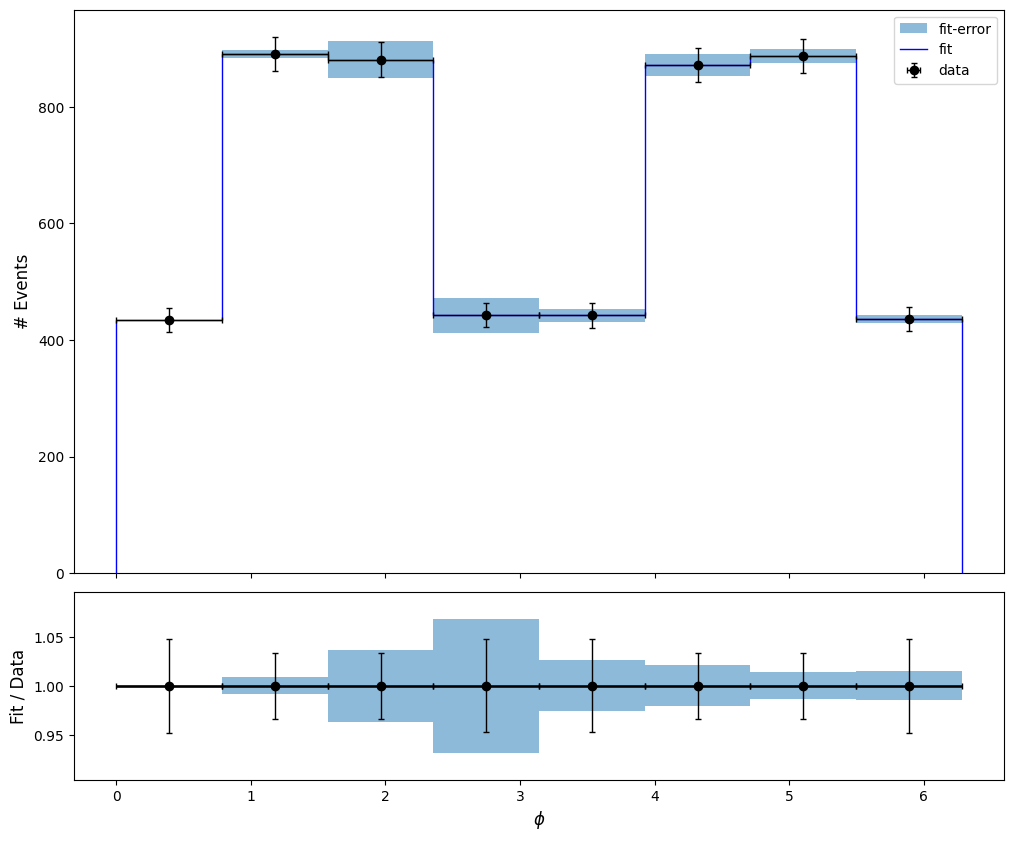

In [20]:
# fig, ax = plt.subplots()
# ax.set_xlabel('$\cos(\\theta)$')
# ax.set_ylabel('#Events')
fig, axs = plot_fit(xe_phi, n_phi, m1, t_phi, xlabel='$\phi$')
prefix = "/home/maltem/Documents/bachlorthesis/"
savekwargs = dict(dpi=300, transparent=True)
fig.savefig(prefix+f"fit__phi_nocoeffs_plot_{cuts}.png", **savekwargs)

In [21]:
# fit cos
mcos = Minuit(TemplateFits_2d(dx_cos, t_cos, n_cos, lumi=lumi), np.ones(9))
mcos.fixed[["x1", "x2", "x3", "x5", "x6", "x7"]] = True
mcos.migrad()
mcos.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.922e+04                 │              Nfcn = 141              │
│ EDM = 2.43e-11 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.000   │   0.026   │   -0.026   │   0.026    │         │         │       │
│ 1 │ x1   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 2 │ x2   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 3 │ x3   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 4 │ x4   │     1     │     7     │     -7     │     7      │         │         │       │
│ 5 │ x5   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 6 │ x6   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 7 │ x7   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 8 │ x8   │   1.000   │   0.014   │   -0.014   │   0.014    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          x0           │          x4           │          x8           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.026   │   0.026   │    -7     │     7     │  -0.014   │   0.014   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬──────────────────────────────────────────────────────────────────────────────────┐
│    │       x0       x1       x2       x3       x4       x5       x6       x7       x8 │
├────┼──────────────────────────────────────────────────────────────────────────────────┤
│ x0 │ 0.000688        0        0        0  -4.3e-3        0        0        0 -0.01e-3 │
│ x1 │        0        0        0        0        0        0        0        0        0 │
│ x2 │        0        0        0        0        0        0        0        0        0 │
│ x3 │        0        0        0        0        0        0        0        0        0 │
│ x4 │  -4.3e-3        0        0        0     50.1        0        0        0  0.69e-3 │
│ x5 │        0        0        0        0        0        0        0        0        0 │
│ x6 │        0        0        0        0        0        0        0        0        0 │
│ x7 │        0        0        0        0        0        0        0        0        0 │
│ x8 │ -0.01e-3        0        0        0  0.69e-3        0        0        0 0.000189 │
└────┴──────────────────────────────────────────────────────

[1.02883403 1.02686138 1.02448697 1.02130655 1.01715235 1.01071689
 0.99923302 0.97189609] [0.97179018 0.9733203  0.97553032 0.97864643 0.98279822 0.98929352
 1.00093587 1.02870849] [0.99999975 1.00000019 1.00000006 1.00000009 0.99999999 1.00000011
 1.00000001 0.99999983]


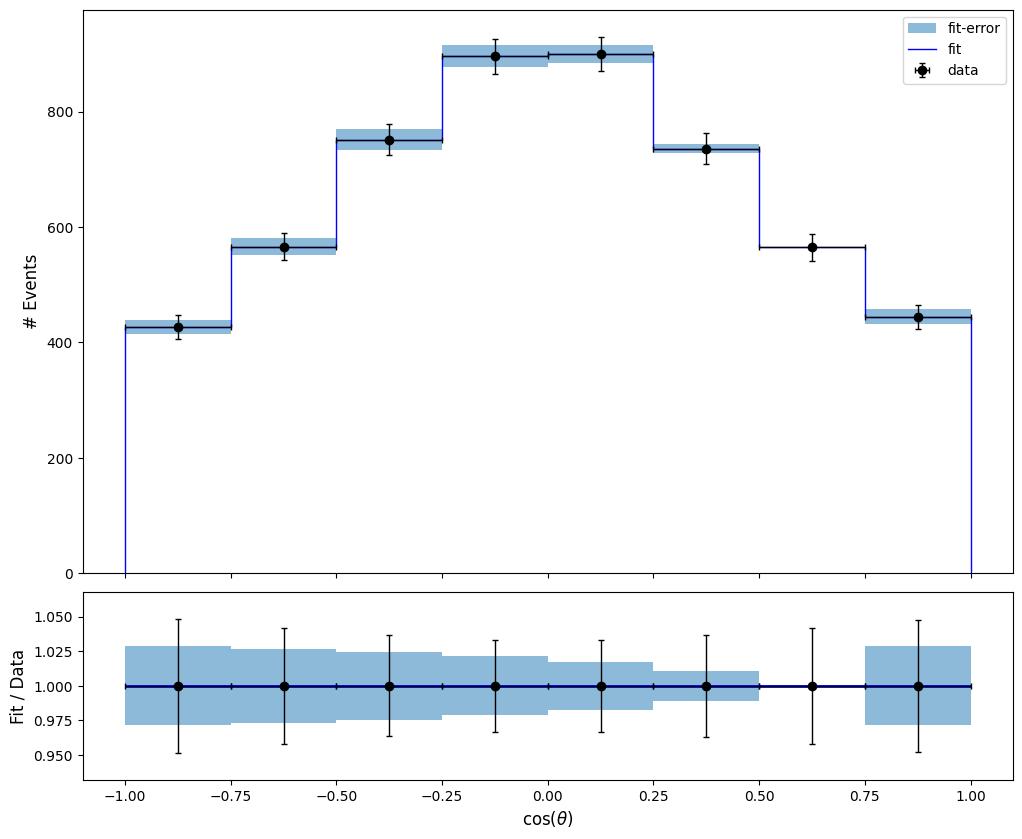

In [22]:
fig, _ = plot_fit(xe_cos, n_cos, mcos, t_cos)
fig.savefig(prefix+f"fit__cos_nocoeffs_plot_{cuts}.png", **savekwargs)

In [23]:
# #fit cos with angular coeffs
# m2 = Minuit(TemplateFits_1set(xe_cos, t_cos, n_cos), np.ones(9))#, coeffs=np.append(coeff, 1)), np.append(coeff, 1))
# m2.fixed[["x1", "x2", "x3", "x5", "x6", "x7"]] = True
# m2.migrad()
# m2.minos()

In [24]:
# fig, ax = plt.subplots()
# ax.set_xlabel('$\cos(\\theta)$')
# ax.set_ylabel('#Events')
# plot_fit(ax, xe_cos, n_cos, m2, t_cos)#, coeffs=np.append(coeff, 1))

In [25]:
# m3 = Minuit(TemplateFits(xe_cos, xe_phi, t_cos, n_cos, t_phi, n_phi), np.ones(9))
# m3.values["x1"] = 0
# m3.fixed["x1"] = True
# m3.values["x6"] = 0
# m3.fixed["x6"] = True
# m3.migrad()
# m3.minos()

In [26]:
# fig, ax = plot_cos_phi(xe_cos, xe_phi, n_cos, n_phi, m3, t_cos, t_phi) # , coeffs=np.append(coeff, 1))

# 2d Fits

In [27]:
# # loading data and templates
# with open("templates/data_2d_nocuts/data_2d.json", "r") as f:
#     data = json.load(f)
# xe = np.array(data["bins"])
# dx = np.array((xe[0,1] - xe[0, 0], xe[1,1] - xe[1, 0]))
# da = np.prod(dx)
# n = np.array(data["zvals"]) * da * lumi
# # n = n.reshape(40,40)
# # cos(theta) along collums
# # phi along rows

# prefix = "templates/2d_nocuts/temps_2D"
# ts = []
# for i in range(9):
#     with open(prefix + str(i) + ".json", "r") as f:
#         ts.append(json.load(f)["zvals"])       
# ts = np.array(ts)

In [28]:
m2d = Minuit(TemplateFits_2d(da, ts.T, n, lumi=lumi),
             np.ones(9))
# m2d.fixed[[0,1,3,4,5,6,7, 8]] = True
m2d.migrad()
m2d.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.857e+04                 │              Nfcn = 872              │
│ EDM = 7.3e-12 (Goal: 0.0001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.000   │   0.027   │   -0.027   │   0.027    │         │         │       │
│ 1 │ x1   │    1.0    │    3.5    │    -3.5    │    3.5     │         │         │       │
│ 2 │ x2   │   1.00    │   0.27    │   -0.27    │    0.27    │         │         │       │
│ 3 │ x3   │     0     │    40     │    -40     │     40     │         │         │       │
│ 4 │ x4   │     1     │     7     │     -7     │     7      │         │         │       │
│ 5 │ x5   │    1.0    │    2.6    │    -2.6    │    2.6     │         │         │       │
│ 6 │ x6   │     1     │    10     │    -10     │     10     │         │         │       │
│ 7 │ x7   │    1.0    │    2.4    │    -2.4    │    2.4     │         │         │       │
│ 8 │ x8   │   1.000   │   0.016   │   -0.016   │   0.016    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          x0           │          x1           │          x2           │          x3           │          x4           │          x5           │          x6           │          x7           │          x8           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.027   │   0.027   │   -3.5    │    3.5    │   -0.27   │   0.27    │    -40    │    40     │    -7     │     7     │   -2.6    │    2.6    │    -10    │    10     │   -2.4    │    2.4    │  -0.016   │   0.016   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴─

In [29]:
m2d = Minuit(TemplateFits_2d(da, ts.T, n, lumi=140, coeffs=np.ones(9)),
             np.ones(9))
# # m2d.fixed[3] = True
# m2d.limits[-1] = [80, 200]
# m2d.fixed[[0,1,2,3,4,5,6,7,8]] = True
# m2d.migrad()
# m2d.fixed=False
# # m2d.fixed[0] = True
# print(m2d.params)
# m2d.fixed[-2] = True
m2d.migrad()
m2d.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.857e+04                 │              Nfcn = 872              │
│ EDM = 7.3e-12 (Goal: 0.0001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.000   │   0.027   │   -0.027   │   0.027    │         │         │       │
│ 1 │ x1   │    1.0    │    3.5    │    -3.5    │    3.5     │         │         │       │
│ 2 │ x2   │   1.00    │   0.27    │   -0.27    │    0.27    │         │         │       │
│ 3 │ x3   │     0     │    40     │    -40     │     40     │         │         │       │
│ 4 │ x4   │     1     │     7     │     -7     │     7      │         │         │       │
│ 5 │ x5   │    1.0    │    2.6    │    -2.6    │    2.6     │         │         │       │
│ 6 │ x6   │     1     │    10     │    -10     │     10     │         │         │       │
│ 7 │ x7   │    1.0    │    2.4    │    -2.4    │    2.4     │         │         │       │
│ 8 │ x8   │   1.000   │   0.016   │   -0.016   │   0.016    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          x0           │          x1           │          x2           │          x3           │          x4           │          x5           │          x6           │          x7           │          x8           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.027   │   0.027   │   -3.5    │    3.5    │   -0.27   │   0.27    │    -40    │    40     │    -7     │     7     │   -2.6    │    2.6    │    -10    │    10     │   -2.4    │    2.4    │  -0.016   │   0.016   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴─

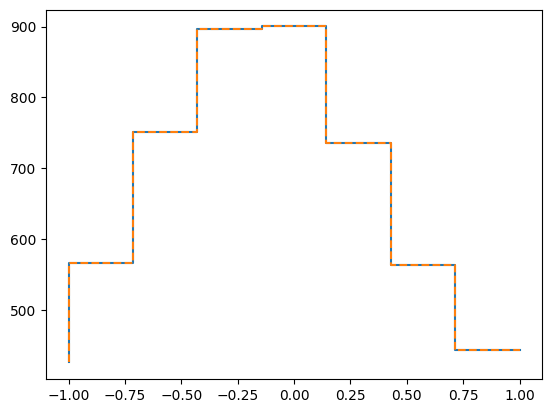

In [30]:
fig, ax = plt.subplots()
nangbins = 8
x = np.linspace(-1, 1, nangbins)
ax.step(x, np.sum(n.reshape(nangbins, nangbins), axis=1))
ax.step(x, n_cos, '--')
# ax.step(x, np.sum(n, axis=0))
# ax.step(x, n_phi, '--')
plt.show()

rebinned_data, rebinned_ts = rebin(n, ts, 5, 5)a

m2drebinned = Minuit(TemplateFits_2d(da, rebinned_ts.T, rebinned_data), np.ones(9))
m2drebinned.migrad()
m2drebinned.minos()

np.abs(np.array(m2d.errors) / np.array(m2drebinned.errors)) - 1

import matplotlib.pyplot as plt
import numpy as np

# Example Data
bins = np.linspace(1000, 7000, 20)  # Bin edges from 1000 to 7000 GeV
data = np.random.poisson(50, len(bins) - 1)  # Simulated Data
mc = np.random.normal(50, 5, len(bins) - 1)  # Simulated Monte Carlo

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 6))

# Plot Data and MC histograms
ax1.step(bins[:-1], data, where='mid', label='Data', linewidth=2, color='black')
ax1.step(bins[:-1], mc, where='mid', label='MC Sample', linewidth=2, color='red')
ax1.set_ylabel(r'$\frac{d\sigma}{dm_{jj}}$ [fb/GeV]')
ax1.legend()
ax1.set_yscale('log')  # Log scale for y-axis if needed
ax1.grid(True)

# Plot MC/Data ratio
ratio = mc / data
ax2.axhline(1, color='gray', linestyle='--')  # Reference line at 1
ax2.step(bins[:-1], ratio, where='mid', color='blue')
ax2.set_ylabel('MC/Data')
ax2.set_xlabel(r'$m_{jj}$ [GeV]')
ax2.set_ylim(0.5, 1.5)  # Adjust y-limits for ratio plot
ax2.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [1]:
sig = 37.4
uncert = 3.5 #np.sqrt(3.5**2 + 5.5**2)
print("rel", uncert / sig)

rel 0.09358288770053476


In [ ]:
37-4